In [1]:
#! pwd
#! pip install netCDF4
#!pip install shap
import numpy as np
from datetime import datetime,timedelta
from netCDF4 import Dataset
import tensorflow as tf
from tensorflow.keras import Model, datasets, layers, models, backend
from tensorflow import keras
from contextlib import redirect_stdout
import os, sys
import psutil, os
#import matplotlib.pyplot as plt
from cftime import num2date, date2num
import matplotlib.pyplot as plt
#! pip install shap
#! pip install visualkeras

2024-10-18 19:56:30.517794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 19:56:30.600348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 19:56:30.691366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 19:56:30.768750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 19:56:30.790715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 19:56:30.908075: I tensorflow/core/platform/cpu_feature_gu

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "gpu_number"
begin_time = datetime.now()
def memory_footprint():
    '''Returns memory (in MB) being used by Python process'''
    mem = psutil.Process(os.getpid()).memory_info().rss
    return (mem / 1024 ** 2)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

import os
os.chdir("/content/gdrive/My Drive/Work/Projects/Oxford_Secondment/Output_model/Data_GRLENSO_2023")
print(os.getcwd())
print(os.listdir())


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Work/Projects/Oxford_Secondment/Output_model/Data_GRLENSO_2023
['thetao_training.nc', 'tos_training.nc', 'uas_training.nc', 'thetao_validation.nc', 'tos_validation.nc', 'uas_validation.nc', 'training_label.nc', 'validation_label.nc', 'tos_thetao_test.nc', 'uas_test.nc', 'test_label.nc', 'nino34.long.anom.data.txt', 'sst.mon.mean.trefadj.anom.1880to2018.nc', 'ENSO_forecasting_original', 'model_last.hdf5', 'model_summary.md', 'test1.pdf', 'model_sst_a1.pdf', 'model_last_sst.hdf5', 'model_summary_sst.md', 'activation_1_channel_10.png', 'activation_1_channel_11.png', 'activation_1_channel_12.png', 'activation_1_channel_13.png', 'activation_1_channel_14.png', 'activation_1_channel_15.png', 'activation_1_channel_16.png', 'activation_1_channel_17.png', 'activation_1_channel_18.png', 'activation_1_channel_19.png', 'activation_1_channel_20

In [ ]:
# input for training data
nr_times = 28764
#nr_times=100
f1 = Dataset('tos_training.nc')
f2 = Dataset('thetao_training.nc')
f3 = Dataset('uas_training.nc')

sst = f1.variables['sst'][0:nr_times,:,:,:]
t300 = f2.variables['sst'][0:nr_times,:,:,:]
uas = f3.variables['sst'][0:nr_times,:,:,:]
tdim, zdim, ydim, xdim = sst.shape
f1.close();f2.close();f3.close()
tdim, zdim, ydim, xdim = sst.shape
#tr_x = np.append(np.append(sst,t300,axis=1),uas,axis=1)
#tr_x  = np.append(sst,t300,axis=1)
tr_x  = uas
del sst, t300,uas
tdim, zdim, ydim, xdim = tr_x.shape
print(tr_x.shape)
tr_x = np.swapaxes(tr_x, 1, 3)

f = Dataset('training_label.nc','r')
tr_y = f.variables['sst'][0:nr_times,:]
print(tr_y.shape)
f.close()

###### input validation data ######
f1 = Dataset('tos_validation.nc')
f2 = Dataset('thetao_validation.nc')
f3 = Dataset('uas_validation.nc')
nr_times = 8459
#nr_times=100
sst = f1.variables['sst'][0:nr_times,:,:,:]
t300 = f2.variables['sst'][0:nr_times,:,:,:]
uas = f3.variables['sst'][0:nr_times,:,:,:]
val_tdim, zdim, ydim, xdim = sst.shape
f1.close();f2.close();f3.close()
tdim, zdim, ydim, xdim = sst.shape
tr_xv = uas
#tr_xv  = np.append(sst,t300,axis=1)
del sst, t300,uas
tdim, zdim, ydim, xdim = tr_xv.shape
print(tr_xv.shape)
tr_xv = np.swapaxes(tr_xv, 1, 3)
f = Dataset('validation_label.nc')
tr_yv  = f.variables['sst'][0:nr_times,:]
print(tr_yv.shape)
f.close()

###### input test data ######

f1 = Dataset('tos_thetao_test.nc')
f2 = Dataset('uas_test.nc')
nr_times2 = 420
#nr_times2 =100
sst = f1.variables['sst'][0:nr_times2,:,:,:]
t300 = f1.variables['hc300'][0:nr_times2,:,:,:]
uas = f2.variables['sst'][0:nr_times2,:,:,:]
test_tdim, _, ydim, xdim = sst.shape
f1.close();f2.close();
tdim, zdim, ydim, xdim = sst.shape
#tr_xt  = np.append(sst,t300,axis=1)
tr_xt=uas
del sst, t300,uas
tdim, zdim, ydim, xdim = tr_xt.shape
print(tr_xt.shape)
tr_xt = np.swapaxes(tr_xt, 1, 3)
f = Dataset('test_label.nc')
tr_yt  = f.variables['sst'][0:nr_times2,:,0,0]
print(tr_yt.shape)
f.close()


(28764, 3, 24, 72)
(28764, 23)
(8459, 3, 24, 72)
(8459, 23)
(420, 3, 24, 72)
(420, 23)


In [ ]:
print(tr_x.shape)

(28764, 72, 24, 3)


In [ ]:
def conv_set(X, n_feat, k_size, act, stride=1):
    conv = layers.Conv2D(n_feat, k_size, activation=act,padding='same', strides=stride)(X)
    return conv

def dense_set(X, n_feat, act):
    dense = layers.Dense(n_feat,activation=act)(X)
    return dense

def max_pool(X):
    pool = layers.MaxPool2D((2,2), strides=2, padding='same')(X)
    return pool

callbacks_list = [

  keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=20,
  ),

  keras.callbacks.ModelCheckpoint(
    filepath='model.hdf5',
    monitor='val_loss',
    save_best_only=True,
  )
]
#inputs = tf.keras.Input(shape=(xdim,ydim,zdim))
inputs = tf.keras.Input(shape=(xdim,ydim,zdim))
print(xdim,ydim)
#conv_f = 35
#dens_f = 50
conv_f = 10
dens_f = 10
## conv 1
print(inputs)
print(conv_f)
conv1 = conv_set(inputs, conv_f, [8,4], 'tanh')
## pool1
pool1 = max_pool(conv1)
## conv2
conv2 = conv_set(pool1, conv_f, [4,2], 'tanh')
## pool2
pool2 = max_pool(conv2)
## conv3
conv3 = conv_set(pool2, conv_f, [4,2], 'tanh')
## flatten
flat = layers.Flatten()(conv3)
dense1 = dense_set(flat, dens_f, 'tanh')
dense2 = dense_set(dense1, dens_f, 'tanh')
output1 = dense_set(dense2, 23, None)
## output2
#output2 = dense_set(dense2, 12, 'softmax')
## model
model = Model(inputs=inputs, outputs=[output1])
###### output1
model.summary()

72 24
KerasTensor(type_spec=TensorSpec(shape=(None, 72, 24, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
10
Model: "model_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 72, 24, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 24, 10)        970       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 36, 12, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 36, 12, 10)        810       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 18, 6, 10)         0         
 g2D)                        

Epoch 1/20
58/58 [==============================] - 106s 2s/step - loss: 0.5782 - val_loss: 0.4197
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 75s 1s/step - loss: 0.4996 - val_loss: 0.4065
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 75s 1s/step - loss: 0.4802 - val_loss: 0.3997
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 73s 1s/step - loss: 0.4643 - val_loss: 0.3970
Epoch 5/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 [==============================] - 74s 1s/step - loss: 0.4539 - val_loss: 0.4029
Epoch 6/20
58/58 [==============================] - 74s 1s/step - loss: 0.4419 - val_loss: 0.4071
Epoch 7/20
58/58 [==============================] - 77s 1s/step - loss: 0.4351 - val_loss: 0.4151
Epoch 8/20
58/58 [==============================] - 71s 1s/step - loss: 0.4280 - val_loss: 0.4157
Epoch 9/20
58/58 [==============================] - 75s 1s/step - loss: 0.4200 - val_loss: 0.4174
Epoch 10/20
58/58 [==============================] - 70s 1s/step - loss: 0.4168 - val_loss: 0.4198
Epoch 11/20
58/58 [==============================] - 74s 1s/step - loss: 0.4129 - val_loss: 0.4276
Epoch 12/20
58/58 [==============================] - 75s 1s/step - loss: 0.4031 - val_loss: 0.4314
Epoch 13/20
58/58 [==============================] - 73s 1s/step - loss: 0.3998 - val_loss: 0.4278
Epoch 14/20
58/58 [==============================] - 80s 1s/step - loss: 0.3960 - val_loss: 0.4334
Epoch 15/20
58/58 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


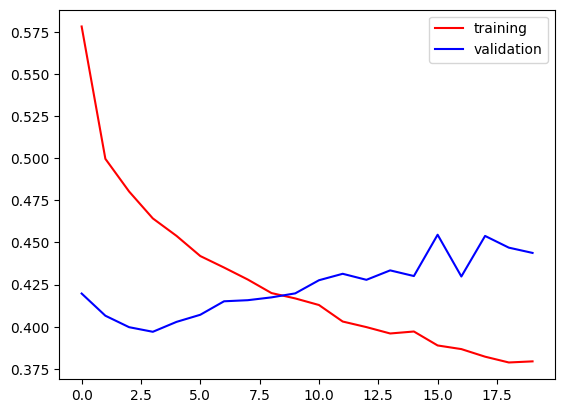

In [ ]:
# compile

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),loss=['mse', 'categorical_crossentropy'],loss_weights=[0.8, 0.2])
history = model.fit(tr_x,tr_y, batch_size=500, epochs=20, verbose=1,callbacks=callbacks_list,validation_data=(tr_xv,tr_yv))
model.save('model_last_uas.hdf5')
history_dict = history.history
tr_loss = history_dict['loss']
val_loss = history_dict['val_loss']

print(tr_loss)
plt.plot(tr_loss,color='red',label='training')
plt.plot(val_loss,color='blue',label='validation')
plt.legend()
plt.savefig("model_uas_a1.pdf")
plt.show()

## save the model summary, logs
with open('model_summary_uas.md', 'w') as f:
       with redirect_stdout(f):
          model.summary()

tr_loss = np.array(tr_loss)
val_loss = np.array(val_loss)


[array([[[[ 1.93118863e-02,  4.11437918e-03,  4.41680029e-02, ...,
           6.97041526e-02,  1.06509149e-01, -1.85045958e-01],
         [-1.43678740e-01,  1.98391706e-01,  3.51940878e-02, ...,
           3.09802834e-02, -1.45060048e-02, -1.05708376e-01],
         [ 3.67405862e-02,  2.96364903e-01,  1.06429569e-01, ...,
          -1.56143427e-01, -1.08894274e-01, -1.13404766e-01]],

        [[ 3.08912862e-02,  1.15165129e-01,  5.12457900e-02, ...,
           5.51780201e-02,  1.79371133e-01, -5.73157482e-02],
         [ 5.51240072e-02,  8.00772235e-02,  1.00352332e-01, ...,
           5.78447096e-02,  8.26323926e-02, -1.02134369e-01],
         [-1.02384523e-01,  2.01600224e-01,  8.60209242e-02, ...,
          -9.42934379e-02, -2.96291709e-01,  1.57499537e-02]],

        [[ 6.58028796e-02,  1.70939803e-01,  8.00573267e-03, ...,
           5.13431169e-02,  9.23267528e-02,  1.27580881e-01],
         [ 7.71151632e-02, -1.08649231e-01, -2.02324465e-01, ...,
           1.06952369e-01, -4.418

print(model.layers[10].get_weights())

In [ ]:
#!/usr/bin/env python
#JHK
import numpy as np
from netCDF4 import Dataset
import tensorflow as tf
from tensorflow.keras import Model, datasets, layers, models, backend
from tensorflow import keras
from contextlib import redirect_stdout
import os, sys

#=======================================================================
# load test input
#=======================================================================
f1 = Dataset('uas_test.nc')
sst = f1.variables['sst']
#tr_xt  = np.append(sst,t300,axis=1)
tr_xt=sst
#del sst, t300,uas
tdim, zdim, ydim, xdim = tr_xt.shape
print(tr_xt.shape)
tr_xt = np.swapaxes(tr_xt, 1, 3)
print(test_tdim)
xdim2 = int(xdim/4)
ydim2 = int(ydim/4)

# [test_tdim,zdim,ydim,xdim] -> [test_tdim,xdim,ydim,zdim]
test_x = np.swapaxes(tr_xt, 1, 3)
test_x = np.transpose(test_x, (0, 3, 2, 1))
#===================================================================
# load model
#===================================================================
model = models.load_model('model_last_uas.hdf5')
print(model)
#===================================================================
# activation conv1 - conv3
#===================================================================
conv1 = model.layers[1](test_x)
print("Conv1 shape",conv1.shape)
max1  = model.layers[2](conv1)
conv2 = model.layers[3](max1)
max2  = model.layers[4](conv2)
conv3 = np.array(model.layers[5](max2)) # [tdim,18,6,35]

#for layer in model.layers:
#    print(layer.name)
#    print(layer.get_weights())

    # Accessing layers, dimensions, and weights from the model
# Accessing layers, layer number, dimensions, and weights from the model
for i, layer in enumerate(model.layers):
    print("Layer Number:", i)
    print("Layer Name:", layer.name)
    print("Layer Input Shape:", layer.input_shape)
    print("Layer Output Shape:", layer.output_shape)
    print("Layer Weights:")
    weights = layer.get_weights()
    for j, weight_array in enumerate(weights):
        print(f"    Weight {j} shape:", weight_array.shape)

#===================================================================
# get parameters
#===================================================================
# dense 1
w1 = np.array(model.layers[7].get_weights()[0]) # [18*6*35,50]
b1 = np.array(model.layers[7].get_weights()[1]) # [50]

# dense 2
w2 = np.array(model.layers[8].get_weights()[0]) # [50,50]
b2 = np.array(model.layers[8].get_weights()[1]) # [50]

# output 1 (Nino3.4)
w_nino = np.array(model.layers[9].get_weights()[0]) # [50,23]
b_nino = np.array(model.layers[9].get_weights()[1]) # [23]


(420, 3, 24, 72)
420
Conv1 shape (420, 72, 24, 10)
Layer Number: 0
Layer Name: input_3
Layer Input Shape: [(None, 72, 24, 3)]
Layer Output Shape: [(None, 72, 24, 3)]
Layer Weights:
Layer Number: 1
Layer Name: conv2d_6
Layer Input Shape: (None, 72, 24, 3)
Layer Output Shape: (None, 72, 24, 10)
Layer Weights:
    Weight 0 shape: (8, 4, 3, 10)
    Weight 1 shape: (10,)
Layer Number: 2
Layer Name: max_pooling2d_4
Layer Input Shape: (None, 72, 24, 10)
Layer Output Shape: (None, 36, 12, 10)
Layer Weights:
Layer Number: 3
Layer Name: conv2d_7
Layer Input Shape: (None, 36, 12, 10)
Layer Output Shape: (None, 36, 12, 10)
Layer Weights:
    Weight 0 shape: (4, 2, 10, 10)
    Weight 1 shape: (10,)
Layer Number: 4
Layer Name: max_pooling2d_5
Layer Input Shape: (None, 36, 12, 10)
Layer Output Shape: (None, 18, 6, 10)
Layer Weights:
Layer Number: 5
Layer Name: conv2d_8
Layer Input Shape: (None, 18, 6, 10)
Layer Output Shape: (None, 18, 6, 10)
Layer Weights:
    Weight 0 shape: (4, 2, 10, 10)
    Weig

In [ ]:
import h5py

def print_hdf5_variables(filename):
    with h5py.File(filename, 'r') as file:
        print("Variables in HDF5 file:", filename)
        print("-----------------------")

        def print_dataset(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Variable: {name}")
                print(f"Shape: {obj.shape}")
                print("-----------------------")

        file.visititems(print_dataset)

# Example usage: Provide the path to your HDF5 file
filename = 'model_last_uas.hdf5'  # replace 'model_last_sst.hdf5' with your actual file path
print_hdf5_variables(filename)


# Outputs of the 8 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)


Variables in HDF5 file: model_last_uas.hdf5
-----------------------
Variable: model_weights/conv2d_6/conv2d_6/bias:0
Shape: (10,)
-----------------------
Variable: model_weights/conv2d_6/conv2d_6/kernel:0
Shape: (8, 4, 3, 10)
-----------------------
Variable: model_weights/conv2d_7/conv2d_7/bias:0
Shape: (10,)
-----------------------
Variable: model_weights/conv2d_7/conv2d_7/kernel:0
Shape: (4, 2, 10, 10)
-----------------------
Variable: model_weights/conv2d_8/conv2d_8/bias:0
Shape: (10,)
-----------------------
Variable: model_weights/conv2d_8/conv2d_8/kernel:0
Shape: (4, 2, 10, 10)
-----------------------
Variable: model_weights/dense_6/dense_6/bias:0
Shape: (10,)
-----------------------
Variable: model_weights/dense_6/dense_6/kernel:0
Shape: (1080, 10)
-----------------------
Variable: model_weights/dense_7/dense_7/bias:0
Shape: (10,)
-----------------------
Variable: model_weights/dense_7/dense_7/kernel:0
Shape: (10, 10)
-----------------------
Variable: model_weights/dense_8/dens

(420, 72, 24, 3)
1/1 [==============================] - 0s 120ms/step


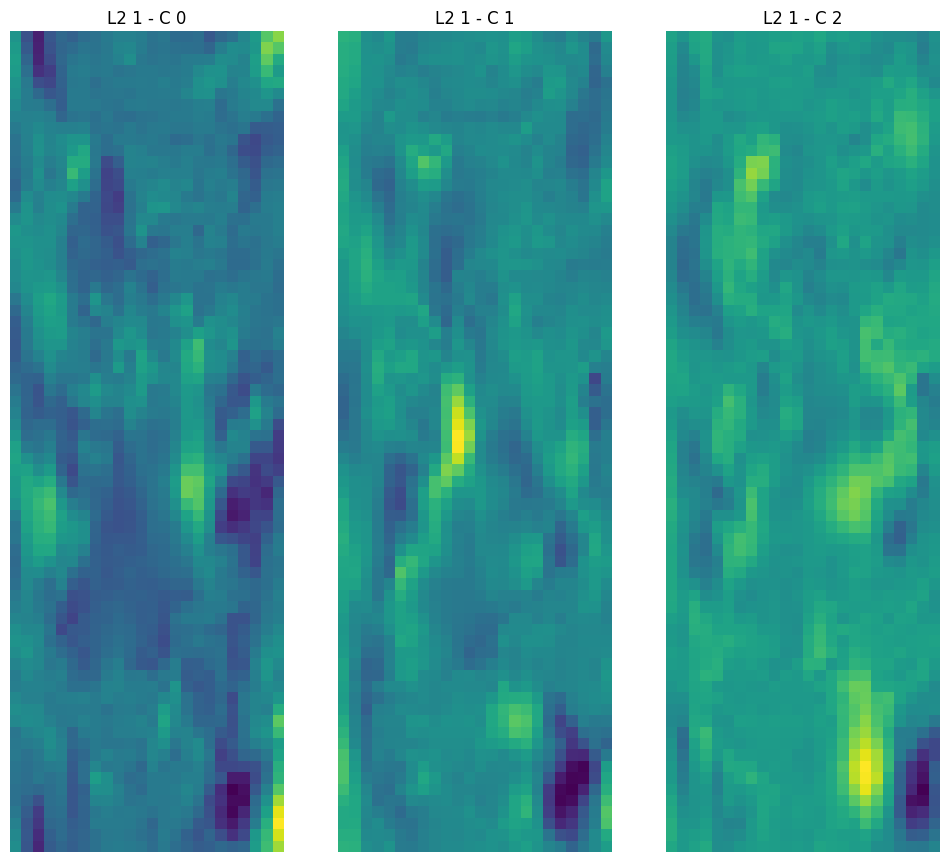

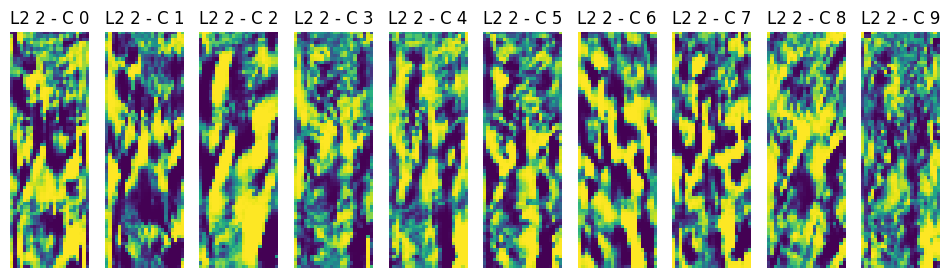

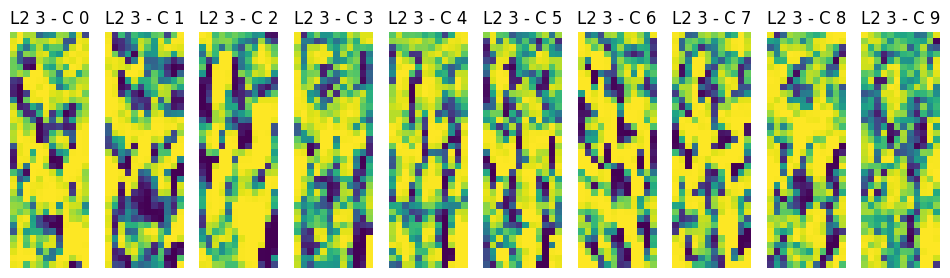

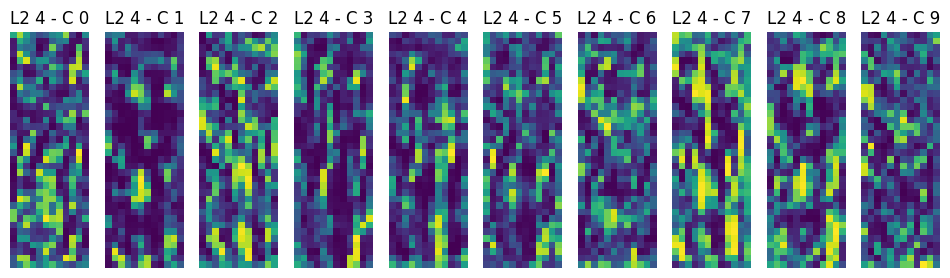

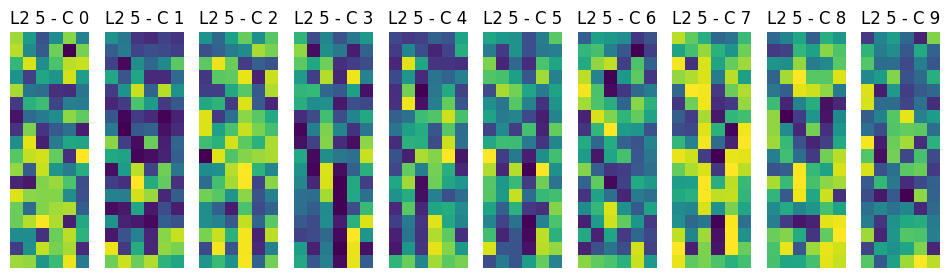

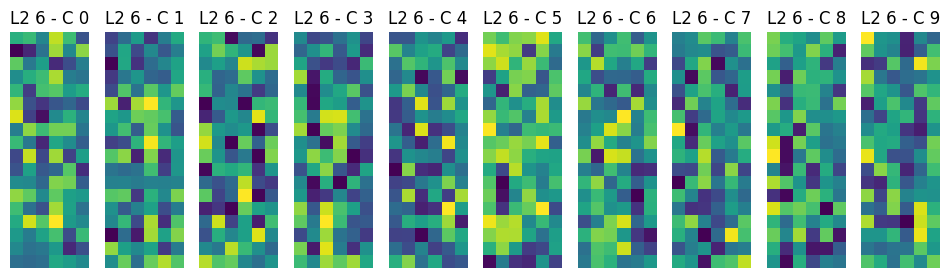

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import h5py
import numpy as np

lat = f1.variables['lat'][:]
lon = f1.variables['lon'][:]
sample_input = test_x[300,:,:,:]
print(test_x.shape)
sample_input = np.expand_dims(sample_input, axis=0)  # Add a new axis for the batch dimension

# Ensure that the shape matches the expected input shape
expected_shape = (1, 72, 24, 3)
if sample_input.shape != expected_shape:
    raise ValueError(f"Expected input shape is {expected_shape}, found {sample_input.shape}")

# Create a model that outputs the activations for each layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

## Get the activations for the sample input
activations = activation_model.predict(sample_input)
## Plot the activations for each layer
for i, activation in enumerate(activations):
   if len(activation.shape) == 4:  # Only plot activations that are in 4D (i.e., feature maps)
        fig, axes = plt.subplots(1, activation.shape[-1], figsize=(12, 12))
        for j in range(activation.shape[-1]):
            axes[j].imshow(activation[0, :, :, j], cmap='viridis')
            axes[j].axis('off')
            axes[j].set_title(f'L2 {i+1} - C {j}')
      #  plt.show()
      # Save the combined plot as an image
plt.savefig('combined_activations_plot_uas.png',dpi=300)

plt.show()

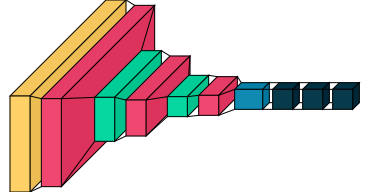

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import visualkeras
import cv2
import numpy as np

# Load and preprocess the input map image
input_map = tr_x[0,:,:,0] # Load the input map image
input_map = cv2.resize(input_map, (24, 72))  # Resize the input map to match model input size
input_map = np.expand_dims(input_map, axis=0)  # Add batch dimension

# Define the model architecture
input_layer = Input(shape=(72, 24, 3), name='input_1')
x = Conv2D(10, (3, 3), activation='relu', name='conv2d')(input_layer)
x = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d')(x)
x = Conv2D(10, (3, 3), activation='relu', name='conv2d_1')(x)
x = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1')(x)
x = Conv2D(10, (3, 3), activation='relu', name='conv2d_2')(x)
x = Flatten(name='flatten')(x)
x = Dense(10, activation='relu', name='dense')(x)
x = Dense(10, activation='relu', name='dense_1')(x)
output_layer = Dense(23, activation='softmax', name='dense_2')(x)

model = Model(inputs=input_layer, outputs=output_layer, name='model')

# Visualize the model architecture with layer dimensions
visualkeras.layered_view(model, to_file='model_with_dims.png', legend=True,scale_xy=4).show()
visualkeras.layered_view(model)
#plt.savefig('model_with_dims.png',dpi=300)  # Save the visualization as a high-resolution image
# Save the input map
#cv2.imwrite('input_map.png', input_map)

In [ ]:
! pip install Basemap

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

lat = f1.variables['lat'][:]
lon = f1.variables['lon'][:]

def preprocess_image(img_path):
    #img = load_and_preprocess_image(img_path)  # Load and preprocess your image
    f1 = Dataset('/content/gdrive/My Drive/Work/Projects/Oxford_Secondment/Output_model/Data_GRLENSO_2023/uas_test.nc')
    tr_xt = f1.variables['sst']
    tr_xt = np.swapaxes(tr_xt, 1, 3)
    sample_input = tr_xt[420,:,:,:]
    print(sample_input.shape)
    img = np.expand_dims(sample_input, axis=0)
    img = tf.image.resize(img, (72, 24))  # Resize the image to match the model input size
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.zeros(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:,:,i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)

    return cam

# Load the image you want to explain
# img = load_image('your_image.jpg')


# Compute Grad-CAM using an existing convolutional layer in your model
explanation1 = grad_cam(model,tr_xt, 'conv2d')  # Use an existing convolutional layer
explanation2 = grad_cam(model,tr_xt, 'conv2d_1')  # Use an existing convolutional layer
explanation3 = grad_cam(model,tr_xt, 'conv2d_2')  # Use an existing convolutional layer

explanation4 = grad_cam(model,tr_xt, 'max_pooling2d')  # Use an existing convolutional layer
explanation5 = grad_cam(model,tr_xt, 'max_pooling2d_1')  # Use an existing convolutional layer

# Create a ScalarMappable object for the colorbar
norm = mcolors.Normalize(vmin=0.2, vmax=1)  # Set the range from 0.2 to 1
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])  # Dummy empty array

cmap = plt.get_cmap('Blues')
new_colors = cmap(np.linspace(0.1, 1, 10))  # Extract colors above 0.1
new_cmap = mcolors.ListedColormap(new_colors)

# Plot the explanation

plt.figure(figsize=(19, 9))
plt.imshow(np.rot90(explanation2),cmap=new_cmap,extent=[lon[0], lon[-1], lat[0], lat[-1]], aspect='auto')
plt.axis('off')

# Create Basemap object for plotting geographic features
m = Basemap(projection='cyl', llcrnrlon=lon[0], llcrnrlat=lat[0], urcrnrlon=lon[-1], urcrnrlat=lat[-1])

    # Add boundaries of continents
m.drawcoastlines(linewidth=1.5, color='black')
m.drawcountries(linewidth=1.5, color='darkgray')

# Add latitude and longitude labels (skipping every 5th value)
m.drawparallels(np.arange(-90, 90, 15), labels=[1,0,0,0], fontsize=10, linewidth=0.5)
m.drawmeridians(np.arange(-180, 180, 20), labels=[0,0,0,1], fontsize=10, linewidth=0.5)

    # Add colorbar under the plot
    # Add colorbar close to the plot
cbar = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Intensity')
#plt.title(' UAS')
#plt.savefig(f'layer_{layer_num}_channel_{channel_num}_uas.png'
plt.savefig('grad_cam_uas.png',dpi=300)
plt.show()
#['input_1', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'flatten', 'dense', 'dense_1', 'dense_2'].




ValueError: No such layer: conv2d. Existing layers are: ['input_3', 'conv2d_6', 'max_pooling2d_4', 'conv2d_7', 'max_pooling2d_5', 'conv2d_8', 'flatten_2', 'dense_6', 'dense_7', 'dense_8'].

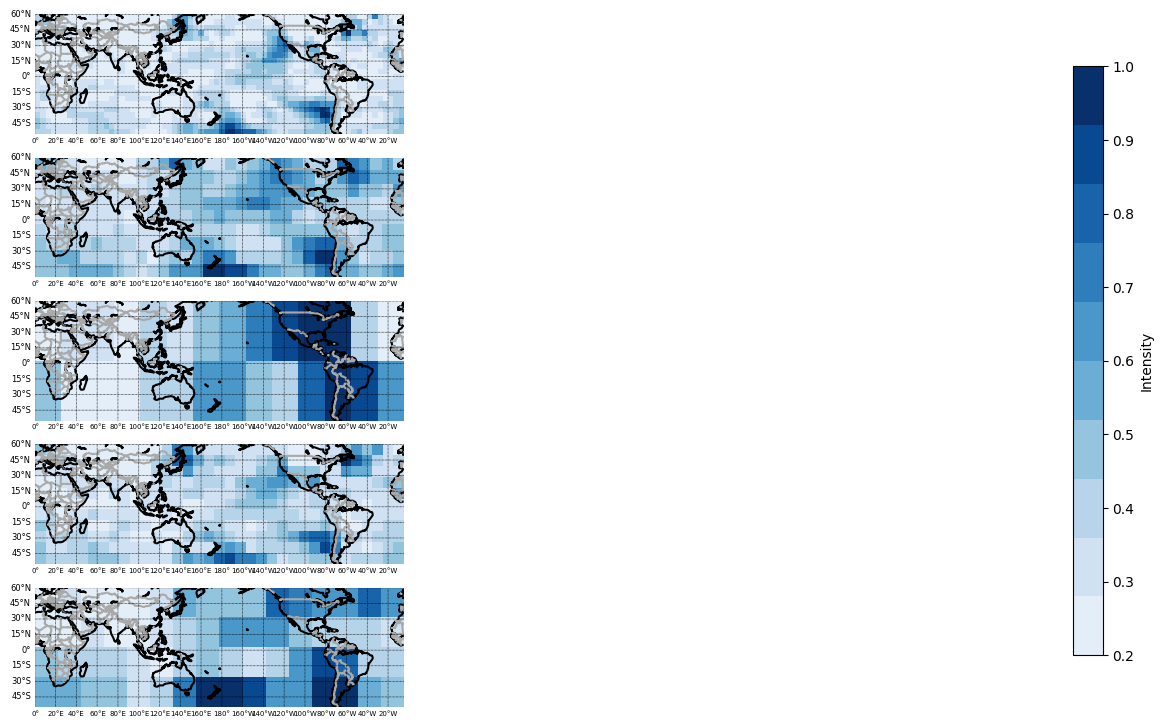

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, axs = plt.subplots(5, 1, figsize=(19, 9))

explanations = [explanation1, explanation2, explanation3,explanation4, explanation5]  # Assuming explanation2 and explanation3 are defined

# Define the custom colormap with limited colors
cmap = plt.get_cmap('Blues')
new_colors = cmap(np.linspace(0.1, 1, 10))  # Extract colors above 0.1
new_cmap = mcolors.ListedColormap(new_colors)

# Create a ScalarMappable object for the colorbar
norm = mcolors.Normalize(vmin=0.2, vmax=1)  # Set the range from 0.2 to 1
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])  # Dummy empty array

cbar = plt.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('Intensity')

for i, ax in enumerate(axs):
    # Plot the explanation
    im = ax.imshow(np.rot90(explanations[i]), cmap=new_cmap, extent=[lon[0], lon[-1], lat[0], lat[-1]], aspect='auto')
    ax.axis('off')

    # Create Basemap object for plotting geographic features
    m = Basemap(projection='cyl', llcrnrlon=lon[0], llcrnrlat=lat[0], urcrnrlon=lon[-1], urcrnrlat=lat[-1], ax=ax)

    # Add boundaries of continents
    m.drawcoastlines(linewidth=1.5, color='black')
    m.drawcountries(linewidth=1.5, color='darkgray')

    # Add latitude and longitude labels (skipping every 5th value)
    m.drawparallels(np.arange(-90, 90, 15), labels=[1, 0, 0, 0], fontsize=6, linewidth=0.5)
    m.drawmeridians(np.arange(-180, 180, 20), labels=[0, 0, 0, 1], fontsize=5, linewidth=0.5)

plt.subplots_adjust(wspace=0.01, left=0.02, right=0.85)  # Adjust subplot and colorbar position
plt.savefig('grad_cam_uas_all_layers.png',dpi=300)
plt.show()
